In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.constants as const
import time

import Bell_EBM as ebm

In [2]:
planetPrime = ebm.Planet('gas', rad=1.800*const.R_jup.value, mass=1.470*const.M_jup.value,
                    Porb=1.09142030, a=0.04340*const.au.value, inc=83.37, vWind=5e3, e=0.3)
starPrime = star = ebm.Star(teff=8300., rad=1.59)

In [21]:
def Optimize(_planet, _star, _error, verbose=False):
    planet = _planet
    star = _star
    aError = _error

    #==========High Res Baseline Creation==========
    tInt = time.time()
    if (verbose == True): 
        print("Starting baseline generation...")

    baseUpdates = 5000. #Amount of timesteps in baseline
    baseOrbits = 2 #Amount of orbits in baseline

    planet.map = ebm.Map.Map(nlat=48)
    system = ebm.System(star, planet)

    Teq = system.get_teq()
    T0 = np.ones_like(system.planet.map.values)*Teq
    t0 = 0.
    t1 = t0+system.planet.Porb*baseOrbits
    dt = system.planet.Porb/baseUpdates
    baselineTimes, baselineMaps, basettc = system.run_model_tester(T0, t0, t1, dt, verbose=False)

    if (planet.orbit.e != 0.):
        T0 = baselineMaps[-1]
        t0 = baselineTimes[-1]
        t1 = t0+system.planet.Porb
        dt = (system.planet.Porb)/1000.
        baselineTimes, baselineMaps, basettc = system.run_model_tester(T0, t0, t1, dt, verbose=False, intermediates=True)
        baselineLightcurve = system.lightcurve(baselineTimes, baselineMaps, bolo=False, wav=4.5e-6)
    else:
        baselineLightcurve = system.lightcurve(baselineTimes, baselineMaps, bolo=False, wav=4.5e-6)

    tFin = time.time()
    if (verbose == True): 
        print("Baseline generation complete; Time to Compute: " + str(round(tFin-tInt,2)) + "s")

    #===========Initial data creationg================
    space_points = 5
    temp_points = 5
    data = np.zeros(shape=((space_points*temp_points),5))
    for i in range (0, temp_points):
        for j in range (0, space_points):
            data[(i*space_points)+j,0]= ((i+1)*250)+0
            data[(i*space_points)+j,1] = ((j+1)*4)+0
    if (verbose == True): 
        print("First pass data points assigned")

    #==================First pass testing Area======================
    phaseBaseline = system.get_phase(baselineTimes).flatten()
    order = np.argsort(phaseBaseline)
    baselineLightcurve = baselineLightcurve[order]
    phaseBaseline = phaseBaseline[order]

    if (verbose == True): 
        print("Starting first pass...")
    tInt = time.time()
    for i in range(0, (space_points*temp_points)):

        planet.map = ebm.Map.Map(nlat=data[i,1])
        system = ebm.System(star, planet)

        TotalTimeToCompute = 0.

        Teq = system.get_teq()
        T0 = np.ones_like(system.planet.map.values)*Teq
        t0 = 0.
        t1 = t0+system.planet.Porb*1
        dt = system.planet.Porb/data[i,0]
        times, maps, ttc = system.run_model_tester(T0, t0, t1, dt, verbose=False)
        TotalTimeToCompute += ttc

        if (planet.orbit.e != 0):
            T0 = maps[-1]
            t0 = times[-1]
            t1 = t0+system.planet.Porb
            dt = system.planet.Porb/data[i,0]
            times, maps, ttc = system.run_model_tester(T0, t0, t1, dt, verbose=False, intermediates=True)
            TotalTimeToCompute += ttc

        testLightcurve = system.lightcurve(times, maps, bolo=False, wav=4.5e-6)

        phaseTest = system.get_phase(times).flatten()
        order = np.argsort(phaseTest)
        testLightcurve = testLightcurve[order]
        phaseTest = phaseTest[order]
        testLightcurve = np.interp(phaseBaseline, phaseTest, testLightcurve)

        data[i,2] = (1e6)*(np.amax(np.absolute(baselineLightcurve - testLightcurve)))
        data[i,4] = TotalTimeToCompute*(1e3)
    tFin = time.time()
    if (verbose == True): 
        print("First pass finished : Time to compute: " + str(round(tFin-tInt,2)) + "s")

    #=================First pass best point===================
    #print(data) #For debugging purposes 
    if (verbose == True):
        print("Processing first pass data...")
    iBest = None
    for i in range(0,space_points*temp_points):
        if (data[i,2]<=(aError*1.05)):
            if (iBest == None):
                iBest = i
            if(data[i,4] < data[iBest,4]):
                iBest = i
                
    #===========Second pass data creation================
    space_points = 5
    temp_points = 5
    dataDouble = np.zeros(shape=((space_points*temp_points),5))
    for i in range (0, temp_points):
        for j in range (0, space_points):
            dataDouble[(i*space_points)+j,0] = ((i)*50)+(data[iBest,0]-100)
            if (dataDouble[(i*space_points)+j,0]<100):
                dataDouble[(i*space_points)+j,0] = 100
            dataDouble[(i*space_points)+j,1] = ((j)*2)+(data[iBest,1]-4)
            if (dataDouble[(i*space_points)+j,1]<2):
                dataDouble[(i*space_points)+j,1] = 2
    if (verbose == True): 
        print("Second pass data points assigned")
    
    #==================Second pass testing Area======================
    phaseBaseline = system.get_phase(baselineTimes).flatten()
    order = np.argsort(phaseBaseline)
    baselineLightcurve = baselineLightcurve[order]
    phaseBaseline = phaseBaseline[order]

    if (verbose == True): 
        print("Starting second pass...")
    tInt = time.time()
    for i in range(0, (space_points*temp_points)):

        planet.map = ebm.Map.Map(nlat=dataDouble[i,1])
        system = ebm.System(star, planet)

        TotalTimeToCompute = 0.
        ttcInt = time.time()
        
        Teq = system.get_teq()
        T0 = np.ones_like(system.planet.map.values)*Teq
        t0 = 0.
        t1 = t0+system.planet.Porb*1
        dt = system.planet.Porb/dataDouble[i,0]
        times, maps, ttc = system.run_model_tester(T0, t0, t1, dt, verbose=False)

        if (planet.orbit.e != 0):
            T0 = maps[-1]
            t0 = times[-1]
            t1 = t0+system.planet.Porb
            dt = system.planet.Porb/dataDouble[i,0]
            times, maps, ttc = system.run_model_tester(T0, t0, t1, dt, verbose=False, intermediates=True)

        testLightcurve = system.lightcurve(times, maps, bolo=False, wav=4.5e-6)

        phaseTest = system.get_phase(times).flatten()
        order = np.argsort(phaseTest)
        testLightcurve = testLightcurve[order]
        phaseTest = phaseTest[order]
        testLightcurve = np.interp(phaseBaseline, phaseTest, testLightcurve)
        
        ttcFin = time.time()
        TotalTimeToCompute = ttcFin - ttcInt
        dataDouble[i,2] = (1e6)*(np.amax(np.absolute(baselineLightcurve - testLightcurve)))
        dataDouble[i,4] = TotalTimeToCompute*(1e3)
    tFin = time.time()
    if (verbose == True): 
        print("Second pass finished : Time to compute: " + str(round(tFin-tInt,2)) + "s")
    
    #=================Finding best second pass point===================
    #print(data) #For debugging purposes 
    if (verbose == True):
        print("Processing second pass data...")
    iBest = None
    for i in range(0,space_points*temp_points):
        if (dataDouble[i,2]<=aError):
            if (iBest == None):
                iBest = i
            if(dataDouble[i,4] < dataDouble[iBest,4]):
                iBest = i

    if (iBest == None):
        print("No points match requested error")
    else:
        print("Temporal: " + str(dataDouble[iBest,0]) + " Spacial: " + str(dataDouble[iBest,1]))
        print("Time for compute: " + str(round(dataDouble[iBest, 4],2)) +"ms : Error: " + str(round(dataDouble[iBest, 2],2)) + "ppm")
        print("Expected compute time @ 1,000,000 cycles: " + str((round((dataDouble[iBest, 4]*1e3/60)/60,2))) + " Hrs")
        
    print(data)
    print(dataDouble)
    #=========Create Maps==================
    if (verbose == True):
        planet.map = ebm.Map.Map(nlat=dataDouble[iBest,1])
        system = ebm.System(star, planet)

        TotalTimeToCompute = 0.

        Teq = system.get_teq()
        T0 = np.ones_like(system.planet.map.values)*Teq
        t0 = 0.
        t1 = t0+system.planet.Porb*1
        dt = system.planet.Porb/dataDouble[iBest,0]
        times, maps, ttc = system.run_model_tester(T0, t0, t1, dt, verbose=False)
        TotalTimeToCompute += ttc

        if (planet.orbit.e != 0):
            T0 = maps[-1]
            t0 = times[-1]
            t1 = t0+system.planet.Porb
            dt = system.planet.Porb/dataDouble[iBest,0]
            times, maps, ttc = system.run_model_tester(T0, t0, t1, dt, verbose=False, intermediates=True)
            TotalTimeToCompute += ttc

        testLightcurve = system.lightcurve(times, maps, bolo=False, wav=4.5e-6)

        phaseTest = system.get_phase(times).flatten()
        order = np.argsort(phaseTest)
        testLightcurve = testLightcurve[order]
        phaseTest = phaseTest[order]
        testLightcurve = np.interp(phaseBaseline, phaseTest, testLightcurve)
        
        plt.plot((baselineLightcurve)*1e6, lw=2, c='g')
        plt.plot((testLightcurve)*1e6, lw=1, c='r')

Starting baseline generation...
Baseline generation complete; Time to Compute: 21.07s
First pass data points assigned
Starting first pass...
First pass finished : Time to compute: 26.06s
Processing first pass data...
Second pass data points assigned
Starting second pass...
Second pass finished : Time to compute: 4.81s
Processing second pass data...
Temporal: 150.0 Spacial: 8.0
Time for compute: 87.04ms : Error: 112.48ppm
Expected compute time @ 1,000,000 cycles: 24.18 Hrs
[[ 250.            4.          217.33742941    0.          111.95492744]
 [ 250.            8.          119.15208864    0.          171.25511169]
 [ 250.           12.           78.07370551    0.          143.19896698]
 [ 250.           16.           56.71492455    0.          240.91625214]
 [ 250.           20.           45.03053       0.          324.58400726]
 [ 500.            4.          214.54639878    0.          217.53120422]
 [ 500.            8.          113.84933451    0.          298.52294922]
 [ 500.     

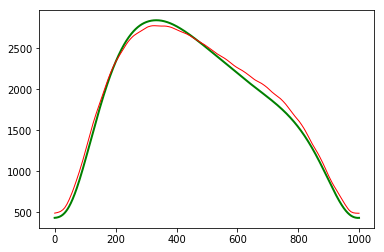

In [22]:
Optimize(planetPrime, starPrime, 125., True)

In [17]:

planet = ebm.Planet('gas', rad=1.800*const.R_jup.value, mass=1.470*const.M_jup.value,
                    Porb=1.09142030, a=0.04340*const.au.value, inc=83.37, vWind=5e3, e=0.3, nlat=16)
star = star = ebm.Star(teff=8300., rad=1.59)
system = ebm.System(star, planet)


baseUpdates = 5000. #Amount of timesteps in baseline
baseOrbits = 2 #Amount of orbits in baseline

planet.map = ebm.Map.Map(nlat=48)
system = ebm.System(star, planet)

Teq = system.get_teq()
T0 = np.ones_like(system.planet.map.values)*Teq
t0 = 0.
t1 = t0+system.planet.Porb*baseOrbits
dt = system.planet.Porb/baseUpdates
baselineTimes, baselineMaps, basettc = system.run_model_tester(T0, t0, t1, dt, verbose=False)

if (planet.orbit.e != 0.):
    T0 = baselineMaps[-1]
    t0 = baselineTimes[-1]
    t1 = t0+system.planet.Porb
    dt = (system.planet.Porb)/1000.
    baselineTimes, baselineMaps, basettc = system.run_model_tester(T0, t0, t1, dt, verbose=False, intermediates=True)
    baselineLightcurve = system.lightcurve(baselineTimes, baselineMaps, bolo=False, wav=4.5e-6)
else:
    baselineLightcurve = system.lightcurve(baselineTimes, baselineMaps, bolo=False, wav=4.5e-6)


    
phaseBaseline = system.get_phase(baselineTimes).flatten()
order = np.argsort(phaseBaseline)
baselineLightcurve = baselineLightcurve[order]
phaseBaseline = phaseBaseline[order]

planet = ebm.Planet('gas', rad=1.800*const.R_jup.value, mass=1.470*const.M_jup.value,
                    Porb=1.09142030, a=0.04340*const.au.value, inc=83.37, vWind=5e3, e=0.3, nlat=8)
star = star = ebm.Star(teff=8300., rad=1.59)
system = ebm.System(star, planet)

TotalTimeToCompute = 0
ttcInt = time.time()
        
Teq = system.get_teq()
T0 = np.ones_like(system.planet.map.values)*Teq
t0 = 0.
t1 = t0+system.planet.Porb*1
dt = system.planet.Porb/1000
times, maps, ttc = system.run_model_tester(T0, t0, t1, dt, verbose=False)

if (planet.orbit.e != 0):
    T0 = maps[-1]
    t0 = times[-1]
    t1 = t0+system.planet.Porb
    dt = system.planet.Porb/500
    times, maps, ttc = system.run_model_tester(T0, t0, t1, dt, verbose=False, intermediates=True)

testLightcurve = system.lightcurve(times, maps, bolo=False, wav=4.5e-6)

phaseTest = system.get_phase(times).flatten()
order = np.argsort(phaseTest)
testLightcurve = testLightcurve[order]
phaseTest = phaseTest[order]
testLightcurve = np.interp(phaseBaseline, phaseTest, testLightcurve)
        
ttcFin = time.time()
TotalTimeToCompute = ttcFin - ttcInt
error = (1e6)*(np.amax(np.absolute(baselineLightcurve - testLightcurve)))
ttc = TotalTimeToCompute*1e3

In [19]:
print(error)
print(ttc)

113.75835028121315
403.28502655029297
